In [1]:
from functools import partial
from itertools import starmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iEEG_utils.loading import read_data
from iEEG_utils.processing import filtering, fooof_mod
# pymultitaper - https://github.com/fncokg/pymultitaper
from pymultitaper import multitaper_spectrogram

rng = np.random.default_rng()

C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:14: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


In [2]:
# use file selection dialog to choose folder with data storage
fstr = read_data.select_directory()
print(fstr)

C:\Users\jmile3\OneDrive - SCH\emotional_faces_data\915b69\RestingState


In [3]:
# IF following JTM's data processing workflow
#### i.e.: 
#### iEEG.csv of timeseries for regions of interest
#### montage.csv of research montage info
#### channels.csv with metadata (loosely following iEEG-BIDS)
# the next line will load the iEEG.csv file and metadata
# can set load_meta = False to just load the timeseries data
# will need sampling rate, though (typically in "channels.csv")

montage = read_data.load_info(fstr,ftype="montage")
montage.name = montage.name.replace(" ","",regex=True)
srate,data = read_data.load_iEEG(fstr,load_meta=True)
# newcols = list(map(lambda x: x.replace(" ",""),data.columns))
data.rename(mapper=dict(zip(data.columns,list(map(lambda x: x.replace(" ",""),data.columns)))),axis='columns',inplace=True)
origtime = pd.to_datetime(data.time,format='%H:%M:%S.%f')
origts = np.array(origtime-origtime[0])/ np.timedelta64(1, 's')

print(srate)
print(data.shape)

display(data.head())

1000
(358000, 28)


,time,LT11,LT12,LE1,LE2,LE12,LE13,LC1,LC2,LC3,...,RG3,RG4,RG5,RB1,RB2,RB3,RB4,RB5,RB6,DC1
0,11:05:31.355627,-19.142032,-23.366569,-74.329246,-3.786173,-20.885492,-20.214930,38.928597,-43.148135,-68.160080,...,49.322301,36.179295,26.657321,-9.888283,4.931127,2.651218,-7.004868,12.441416,45.567156,-2197.26
1,11:05:31.356627,-19.879649,-24.104187,-78.620840,-4.456734,-17.935021,-19.477313,44.695426,-40.197664,-70.305877,...,55.089130,39.733271,33.161768,-9.888283,10.027395,7.076924,-5.529633,14.587213,47.712953,-2197.26
2,11:05:31.357627,-18.337358,-24.104187,-82.912433,-2.243881,-6.937812,-4.121453,48.249402,-37.984811,-71.714056,...,45.500100,30.881859,25.047973,-18.605583,7.143980,3.388836,-12.838753,9.490946,41.812012,-2197.26
3,11:05:31.358627,-17.599740,-24.841805,-84.991174,-0.031028,-12.034079,-9.955339,50.395199,-37.247193,-73.859853,...,48.316458,32.222982,24.980917,-23.701850,5.668745,4.864071,-12.838753,9.423890,41.074394,-2197.26
4,11:05:31.359627,-18.270302,-24.841805,-83.448883,2.852387,-21.421941,-23.098345,52.540996,-37.180137,-73.055179,...,56.296141,38.727428,30.010129,-25.110029,7.143980,10.697956,-9.217721,14.520157,43.220191,-2197.26


In [4]:
montage

,ID,age,region,ch,name
0,2242220,8.58,r_inferiortemporal,85,RG2
1,2242220,8.58,r_inferiortemporal,86,RG3
2,2242220,8.58,r_inferiortemporal,87,RG4
3,2242220,8.58,r_inferiortemporal,88,RG5
4,2242220,8.58,r_entorhinal,92,RB1
5,2242220,8.58,r_entorhinal,93,RB2
6,2242220,8.58,r_entorhinal,94,RB3
7,2242220,8.58,r_entorhinal,95,RB4
8,2242220,8.58,r_fusiform,96,RB5
9,2242220,8.58,r_fusiform,97,RB6


In [27]:
# rate to resample to (best if power of 2)
resrate = 1024
# upper bound of frequency range (must be < resrate/2)
lpfreq = 150
ch1 = "LE1"
ch2 = "LE2"
ts,reref = filtering.bipolar_reref(data.loc[:,[ch1,ch2]], srate, resrate, lpfreq=lpfreq)


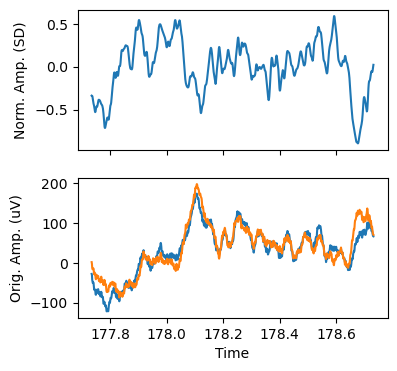

In [28]:
t1 = rng.integers(resrate, high=len(reref))
t0 = t1-resrate
tfilt = (origts>=ts[t0]) & (origts<=ts[t1])
fig, ax = plt.subplots(2,1,sharex=True,figsize=[4,4])
ax[0].plot(ts[t0:t1],reref[t0:t1])
ax[1].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch2],data.loc[tfilt,ch1]]).T,srate,4,[59,61],"stop"))
ax[0].set_xlabel("")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Norm. Amp. (SD)")
ax[1].set_ylabel("Orig. Amp. (uV)")
plt.show()

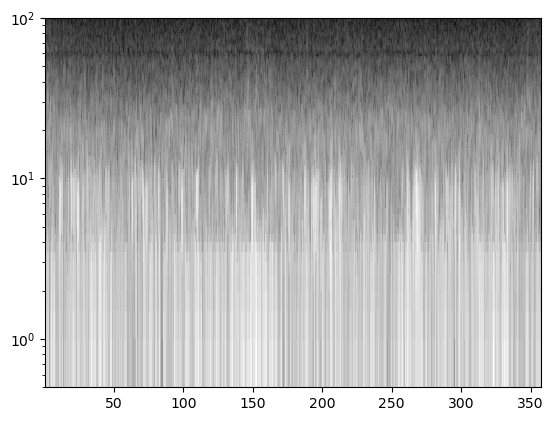

In [29]:
# process data from each subj
# set some parameters that will be used for processing
#####
t_res = 1/4 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 1 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
####

f,sts,spectra = multitaper_spectrogram(reref,resrate,time_step=t_res,window_length=t_win,NW=3,
                                       detrend='off',freq_range=[fmin, fmax],nfft=2*t_win*resrate,
                                       db_scale=False,boundary_pad=False)

fig, ax = plt.subplots()
ax.pcolormesh(sts,f,np.log10(spectra[1:,1:]),cmap="grey", shading="flat")
ax.set_ylim([fmin,fmax])
ax.set_yscale("log")
plt.show()

In [30]:
# fit 1/f with Lorentzian
spect_fits = fooof_mod.fit_group(f,spectra.T)


Running FOOOFGroup across 1429 power spectra.


In [31]:
model_spect = fooof_mod.model_spect
intfs = np.concatenate((np.linspace(0.5,1,sum(f>50)+1),np.linspace(1.05,10,sum(f>10)),f[f>10]))
rowixs = [[ix] for ix in range(max(spectra.shape))]
partial_func = partial(model_spect,model_obj=spect_fits,freqs=f,intfs=intfs,save_fit=True)
calc_resids = starmap(partial_func,rowixs)
resid_spects = np.array(list(calc_resids))

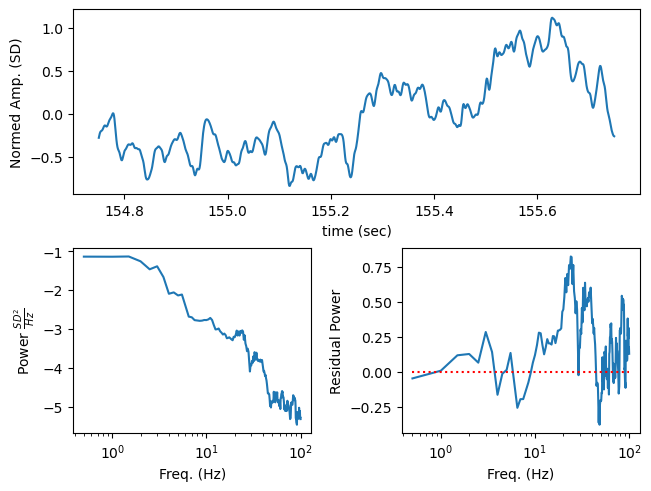

In [32]:
randix = rng.integers(0, high=max(resid_spects.shape))
randt = sts[randix]
plot_ixs = (ts>=randt-(t_win/2))&(ts<=randt+(t_win/2))

fig = plt.figure(layout="constrained")

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(ts[plot_ixs],reref[plot_ixs])
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("Normed Amp. (SD)")

ax2.plot(f,np.log10(spectra[:,randix]))
ax2.set_xscale("log")
ax2.set_xlabel("Freq. (Hz)")
ax2.set_ylabel("Power "+ r'$\frac{SD^2}{Hz}$')

ax3.plot(f,resid_spects.T[:,randix])
ax3.plot([f[0],f[-1]],[0,0],"r:")
ax3.set_xlabel("Freq. (Hz)")
ax3.set_ylabel("Residual Power")
ax3.set_xscale("log")

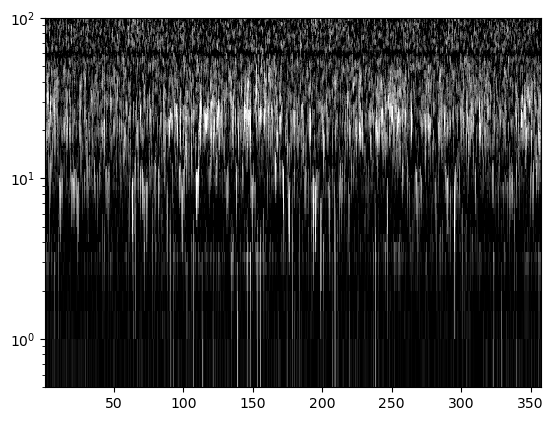

In [33]:
fig, ax = plt.subplots()
ax.pcolormesh(sts,f,resid_spects[1:,1:].T,vmin=0, vmax=1,
              cmap="grey",shading="flat")
ax.set_ylim([fmin,fmax])
ax.set_yscale("log")
plt.show()